In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

In [2]:
def scale_factor_spectrum(z,data,error,wave):
    k = 1+z
    select1 = (wave>6750*k) & (wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact

In [15]:
def aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2=False,MC_loops=100):
    if broad2:
        full_gauss = full_gauss2_flux
    else:
        full_gauss = full_gauss1_flux
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(mini_wave,int_spectrum,int_err),maxfev = 10000000)       
    fitted=(full_gauss(popt_full_fit,mini_wave,int_spectrum,int_err))*(int_err)+int_spectrum 
    residual = int_spectrum - fitted
    v_out = popt_full_fit[2] - popt_full_fit[6]
    (amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c) = popt_full_fit
    sigma_eff_Hb1 = line_width_recons(vel_sigma_Hb1,rest_line=4861.33,inst_res_fwhm=0)
    sigma_eff_Hb2 = line_width_recons(vel_sigma_Hb2,rest_line=4861.33,inst_res_fwhm=0) 
    flux = flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2)
    Hb_lum = Hb_blr_lum(z,flux)          
    cor_popt = np.array([amp_OIII5007,amp_OIII5007_br,vel_OIII,vel_sigma_OIII,vel_OIII_br,vel_sigma_OIII_br])
    (wav_min,wav_max) = wavlim(vel_OIII,vel_OIII_br)
    w80 = line_shape_par(z,wav_min,wav_max,cor_popt)
    parameters = [amp_Hb,amp_OIII5007,vel_OIII,vel_sigma_OIII,amp_Hb_br,amp_OIII5007_br,vel_OIII_br,vel_sigma_OIII_br,amp_Hb1,amp_Fe5018_1,vel_Hb1,vel_sigma_Hb1,amp_Hb2,amp_Fe5018_2,vel_Hb2,vel_sigma_Hb2,m,c,v_out,w80,Hb_lum]

    spec_parameters_MC = np.zeros((len(parameters),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(int_spectrum,int_err)   
        popt_MC,pcov_MC = leastsq(full_gauss,x0=p_init,args=(mini_wave,iteration_data,int_err),maxfev = 10000000)
        v_out_MC = popt_MC[2] - popt_MC[6]
        (amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC) = popt_MC
        sigma_eff_Hb1_MC = line_width_recons(vel_sigma_Hb1_MC,rest_line=4861.33,inst_res_fwhm=0)
        sigma_eff_Hb2_MC = line_width_recons(vel_sigma_Hb2_MC,rest_line=4861.33,inst_res_fwhm=0) 
        flux_MC = flux_blr(amp_Hb1_MC,amp_Hb2_MC,sigma_eff_Hb1_MC,sigma_eff_Hb2_MC,broad2)
        Hb_lum_MC = Hb_blr_lum(z,flux_MC)  
        cor_popt_MC = np.array([amp_OIII5007_MC,amp_OIII5007_br_MC,vel_OIII_MC,vel_sigma_OIII_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC])
        (wav_min,wav_max) = wavlim(vel_OIII_MC,vel_OIII_br_MC)
        try:
            w80_MC = line_shape_par(z,wav_min,wav_max,cor_popt_MC)
        except IndexError:
            w80_MC = vel_sigma_OIII_MC*3.29
        par_MC = [amp_Hb_MC,amp_OIII5007_MC,vel_OIII_MC,vel_sigma_OIII_MC,amp_Hb_br_MC,amp_OIII5007_br_MC,vel_OIII_br_MC,vel_sigma_OIII_br_MC,amp_Hb1_MC,amp_Fe5018_1_MC,vel_Hb1_MC,vel_sigma_Hb1_MC,amp_Hb2_MC,amp_Fe5018_2_MC,vel_Hb2_MC,vel_sigma_Hb2_MC,m_MC,c_MC,v_out_MC,w80_MC,Hb_lum_MC]
        spec_parameters_MC[:,l]=par_MC
    spec_parameters_err = np.nanstd(spec_parameters_MC,1)
    return parameters,spec_parameters_err,fitted,residual



In [16]:
def flux_blr(amp_Hb1,amp_Hb2,sigma_eff_Hb1,sigma_eff_Hb2,broad2=False):
    flux1 = amp_Hb1*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb1))
    flux2 = amp_Hb2*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb2)) 
    if broad2:
        flux = (flux1 + flux2)*(10**(-16))
    else:
        flux = flux1*(10**(-16)) 
    return flux

def Hb_blr_lum(z,flux):
    cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
    D_L = cosmo.luminosity_distance(z)
    dist = D_L.to(u.cm)
    Hb_lum = np.log10(4*np.pi)+2*np.log10(dist.value)+np.log10(flux)
    return Hb_lum
    
def line_shape_par(z,wav_min,wav_max,cor_popt):
    c = 3*(10**5)
    wave = np.arange(wav_min,wav_max,0.02) 
    cumsum = np.cumsum(OIII_wo_cont(wave,*cor_popt))
   # print (cumsum)
    norm_sum=cumsum/cumsum[-1]
    
    select = (norm_sum>0.1) & (norm_sum<0.9)
    w80_spec = wave[select][-1]-wave[select][0]
 
    w80 = ((w80_spec)/5006.8)*(c/(1+z))
    return w80


In [17]:
def central_table(obj,output_par,output_par_err,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'v_outflow':18,'w80':19,'log_Hb_lum':20}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[output_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[output_par_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)

def central_table_with_source(obj,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_nonspectro_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_nonfixkin_aperture.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2=False,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit,v_out_fit,w80_fit,Hb_lum_fit) = popt
    output_par = [amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit] 
    k = 1+z
    if broad2:
        full_gauss = full_gauss2_flux
    else:
        full_gauss = full_gauss1_flux

    fit = full_gauss(output_par,mini_wave,int_spectrum,int_err)*(int_err)+int_spectrum
    residual = int_spectrum - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(mini_wave,int_spectrum,'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(mini_wave,fit,'r:',label='fit')
    plt.plot(mini_wave,Hb_O3_gauss_flux(mini_wave,amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(mini_wave,Hb_O3_gauss_flux(mini_wave,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(mini_wave,Hb_Fe_doublet_gauss_flux(mini_wave,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss_flux(mini_wave,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    #plt.plot(wo_wave[select],residual,label='residual')
    #plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(wo_wave[select],m_fit,c_fit),'-c',label='BLR2')
    #plt.title('All Components'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/Aperture Spectrum/Fit/%s_central_spectrum_components.png'%(destination_path_cube,obj),overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(mini_wave,residual/int_err,drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/Aperture Spectrum/Residuals/%s_central_spectrum_components.png'%(destination_path_cube,obj),overwrite=True)

    #fig.savefig('%s/Spectrum/%s_central_spectrum_full.png'%(destination_path_cube,obj),overwrite=True)
    

In [12]:
def spectroastrometric_script(obj,p_init,z,broad2,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    k = 1+z
    print ('%s'%(obj))
    (mini_cube,mini_err,mini_wave,mini_header) = loadCube('%s/%s/%s.3_arcsec_minicube.fits'%(destination_path_cube,obj,obj))
    (int_spectrum,int_err) = int_spec(mini_cube,mini_err)
    (popt,popt_err,fitted,residual) = aperture_spec_fit(z,int_spectrum,int_err,mini_wave,p_init,broad2,MC_loops=1)
    print (popt,popt_err)
    plot(obj,mini_wave,int_spectrum,int_err,z,popt,broad2)
    
    #central_table(obj,popt,popt_err)
    #central_table_with_source(obj)

HE0227-0913
[324.13926232775736, 541.1314295799621, 4793.753753316203, 139.988363682668, 362.42185134698707, 109.67455803441568, 4344.415636072457, 307.0616858613857, 2396.3540357507645, 380.5158593271884, 4710.232806264138, 1336.759179554162, 1534.6205813499419, 377.84616471434265, 4919.978802141869, 381.242377617945, -8.73429434011223, 87.26922416852648, 449.3381172437457, 732.1434131760332, 42.97358784166101] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


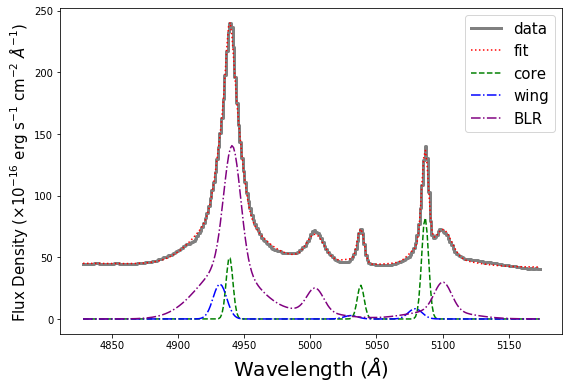

No handles with labels found to put in legend.


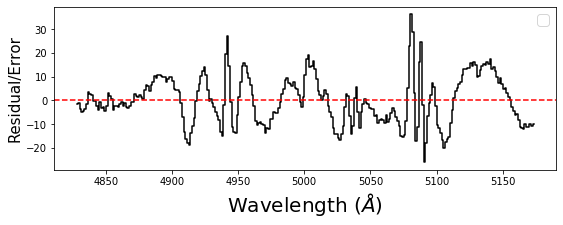

In [13]:
z = {"HE0227-0913":0.016451}

objs = z.keys()

broad2= {'HE0227-0913':True}
#'HE0021-1810':False,
p_init= {'HE0227-0913':[50.394679609204886, 82.38595301209206, 4793.553851128582, 139.88069655713375, 28.334366378774646, 8.270912161070783, 4343.3627305096015, 308.9287526642564, 43.58112286442538, 6.768950196643075, 4712.578629985357, 1342.2135348231159, 97.23593356125787, 23.388212689292676, 4919.903960937358, 381.7006010971896, -8.85811095519379, 87.8870426811849]}
#'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15956,100.0,1.0,1.0,16056,1000.0,0,0,16056,1000.0,-0.001,2.0]
        
for obj in objs:
    spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj])   

HE0021-1810
[6.5816782317647835, 94.41987348738023, 16109.274113362682, 109.8463630544383, 3.6599469922564283, 131.17076088271017, 16010.524578807419, 300.1271009203406, 116.66122023171964, 189.60025309620255, 10852.05861533095, 2396.976488854964, 0.0, 0.0, 15959.0, 1000.0, 1.1242506177433873, 1.9779640193303205, 98.74953455526338, 655.1951977392599, 42.89183396974692] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


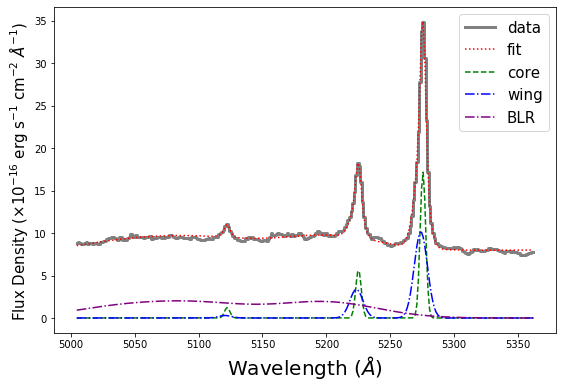

No handles with labels found to put in legend.


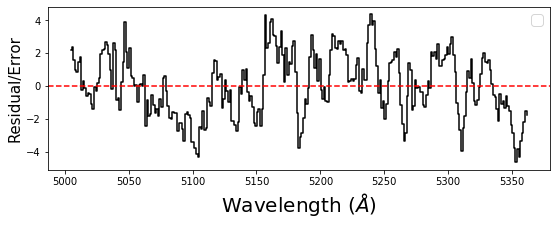

HE0021-1819


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[16.107037256517085, 187.78220240913836, 15957.509993688314, 73.07816684233431, 30.186425941048697, 108.92311017589235, 15831.53625915816, 300.497114562328, -592270.7782604473, -75.14394406329028, 1251.2207719848948, -1736.379851200168, 0.0, 0.0, 15959.0, 1000.0, -4.326366591906118, 24.43114407381959, 125.97373453015462, 613.2960374085683, nan] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. nan]


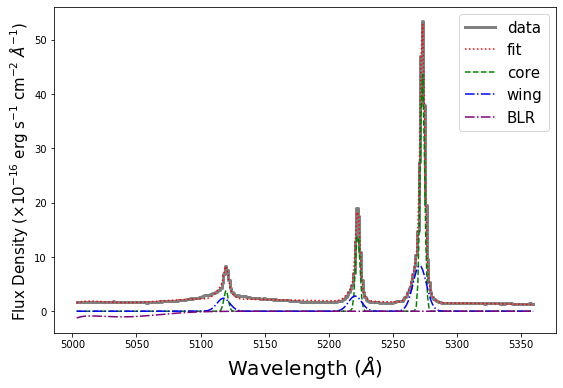

No handles with labels found to put in legend.


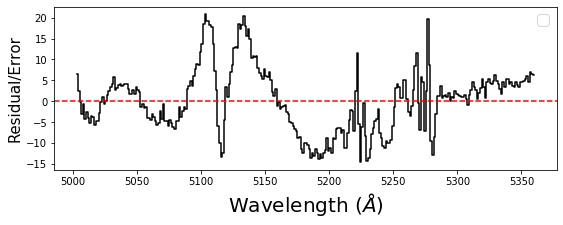

HE0040-1105


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


[52296.64007539997, 162446.1654924991, 3634.3402433977376, -1820.1069202249118, -53053.37079315419, -162941.84213399855, 3632.751235781473, -1832.0384195071235, -28.293959186119558, 159.75494632155008, 11819.620143827877, -275.8461423885949, 0.0, 0.0, 12507.0, 1000.0, -23.12611537287338, 126.7950901490993, 1.5890076162645528, 6813.863207663417, nan] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


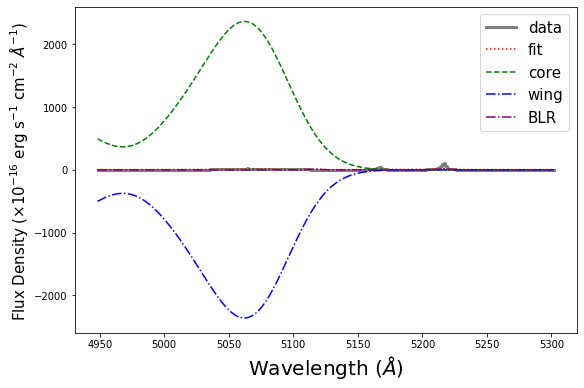

No handles with labels found to put in legend.


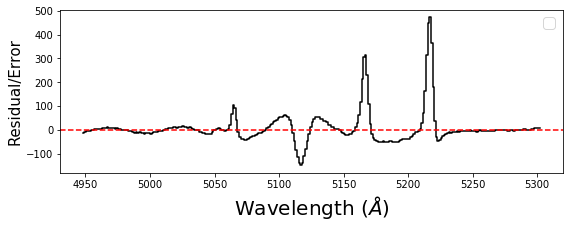

HE0108-4743
[134.3462091620917, 294.1984780130653, 7162.163180509872, 41.60465814989426, 22.84223152608324, 331.958947375724, 7104.024008070234, 112.56138707351259, 310.87369334017194, 96.69255482567388, 7033.533842779394, 1276.3145084115743, 367.0765658670033, 67.4011513737518, 7182.031422376336, 430.4592320978051, 2.3371370082917005, -0.2258116273359844, 58.13917243963806, 250.46021792501952, 42.46904962578852] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


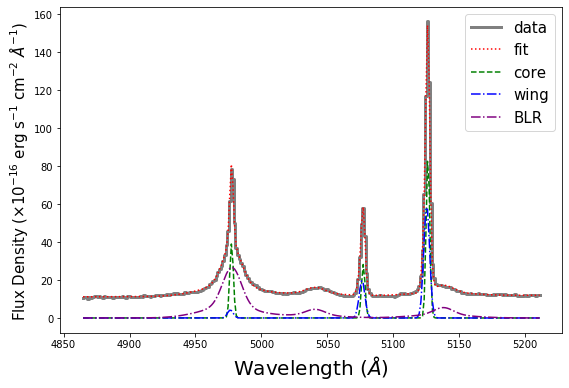

No handles with labels found to put in legend.


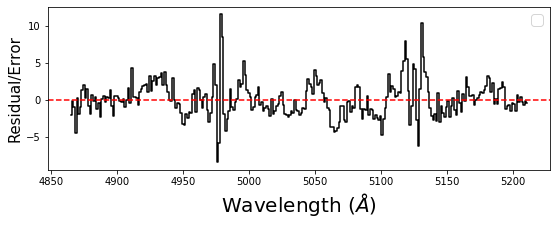

HE0114-0015


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[57.73630242694963, 61.92450541645298, 13674.502848464386, 131.79434374877613, 87.53559534525559, 24.401534558796882, 13867.114781834167, 1401.9556432368938, -883.8958425233689, 21.830966021851005, 189511.02791467297, -15057.788742141609, 0.0, 0.0, 13680.0, 1000.0, -0.058799787471472534, 1.7119612578608019, -192.61193336978067, 3115.120742667548, nan] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. nan]


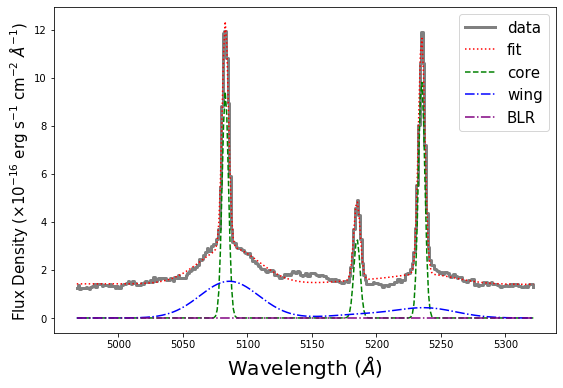

No handles with labels found to put in legend.


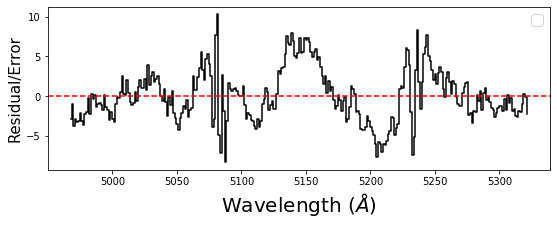

HE0119-0118
[105.55399439261812, 485.6947741438885, 16343.617637887151, 111.51372535685434, 9.8374356722876, 649.8230922377177, 16121.06549052035, 235.01460264301122, 1578.1059729722556, 311.27377186377396, 15980.540450674142, 1852.667748854181, -266.61517244307765, -8.62387077292188, 14601.383396061638, 863.8478724146223, -11.187253244756153, 74.77971365411696, 222.55214736680136, 560.3467158634002, 43.888606039802056] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


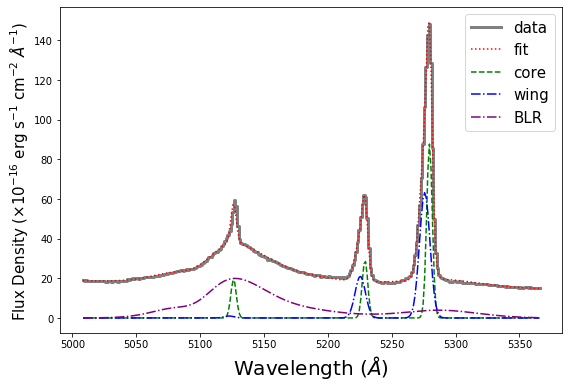

No handles with labels found to put in legend.


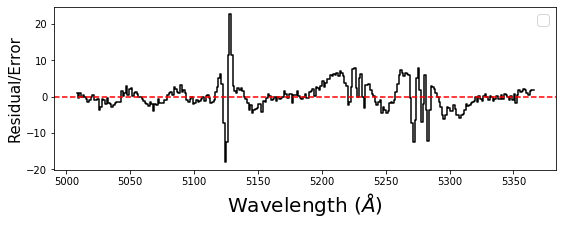

HE0212-0059


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  


[35.116369968486936, 432.33373018636297, 7919.86430118872, 171.60030293219765, 27.945672423785748, 117.38049009314665, 7660.132571197891, -463.57110075144266, 31.94930383160959, 43.661760020468556, 5074.843099977931, 821.4648288356028, -696.2199633467403, 246.51037074408043, 279.8307382416192, 2420.4396048851254, -18.470333471787132, 105.27887641486612, 259.7317299908291, 818.4623915867135, nan] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


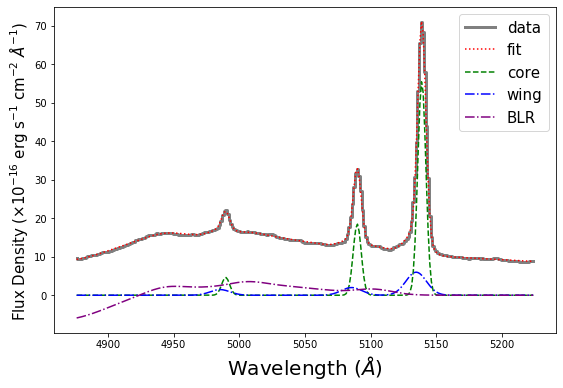

No handles with labels found to put in legend.


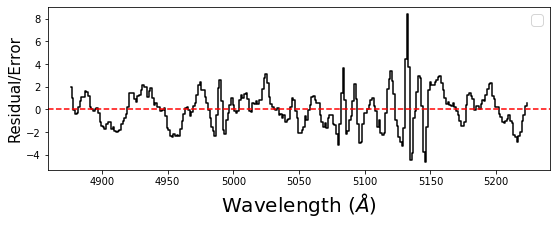

HE0224-2834
[27.697050455653653, 320.4669180795142, 17987.941207966305, 112.41574318651563, 20.03676210901956, 192.42815758074855, 17960.88707463711, 274.5217068306437, 607.9624231766985, 102.89433170107023, 17976.848611432026, -2194.0958510476808, 0.0, 0.0, 0.0, 0.0, -1.8648454985210692, 17.124430974893027, 27.054133329194883, 511.09958281971416, 43.66398897573396] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


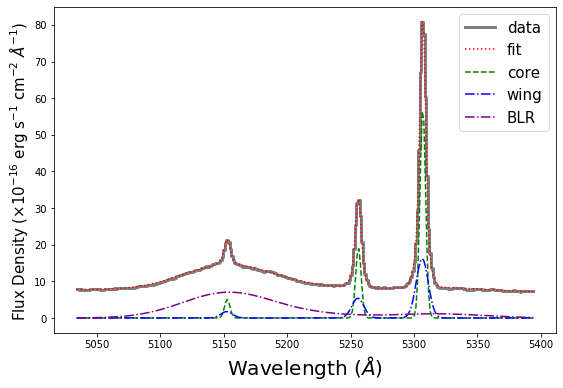

No handles with labels found to put in legend.


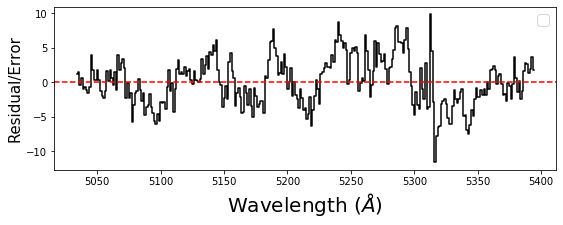

HE0227-0913
[324.13926232775736, 541.1314295799621, 4793.753753316203, 139.988363682668, 362.42185134698707, 109.67455803441568, 4344.415636072457, 307.0616858613857, 2396.3540357507645, 380.5158593271884, 4710.232806264138, 1336.759179554162, 1534.6205813499419, 377.84616471434265, 4919.978802141869, 381.242377617945, -8.73429434011223, 87.26922416852648, 449.3381172437457, 732.1434131760332, 42.97358784166101] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


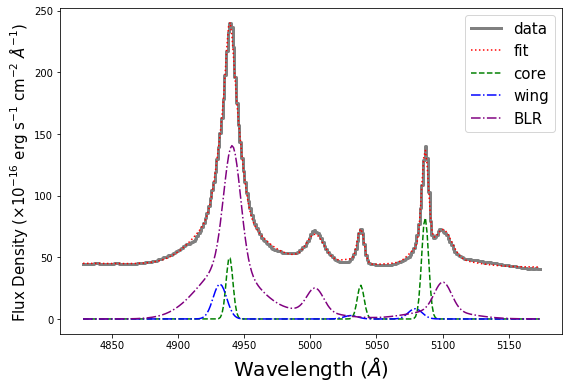

No handles with labels found to put in legend.


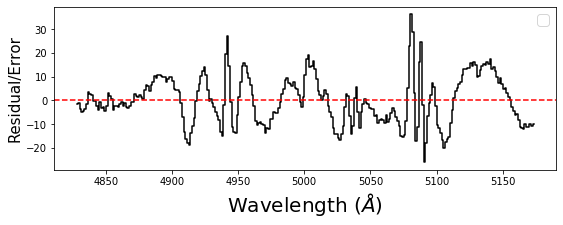

HE0232-0900
[415.5123697755742, 4461.495415659655, 12876.566796045467, 145.24432956535296, -7.975994859032621, 2273.7615821227173, 12840.87771402969, 327.4624642665095, 8795.85977362519, 1312.4035786282977, 12913.174061779626, 2200.0723337066115, 0.0, 0.0, 12942.0, 1000.0, -53.26793998687979, 375.0641217258108, 35.689082015776876, 595.0821432568938, 44.53795208143022] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


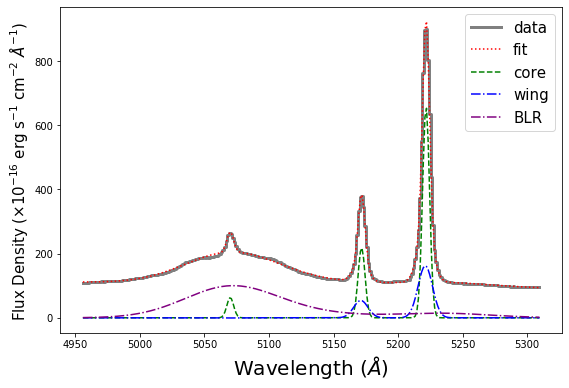

No handles with labels found to put in legend.


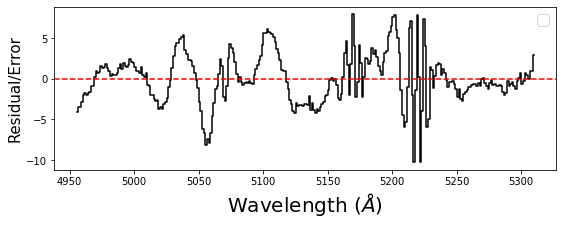

HE0253-1641
[101.81526332117045, 1029.172143400406, 9545.047443691918, -106.29220682318652, 146.9096343185413, 1010.666160743621, 9297.433044403011, 364.2030856822165, 600.3990572095216, 163.4478010230244, 9728.219350416355, 564.8650100504426, 1057.3869591628113, 255.04330732769762, 9162.43141514881, 1721.112906552938, -1.3778207324821392, 46.97365019260919, 247.6143992889065, 817.8193546632222, 43.30639380908358] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


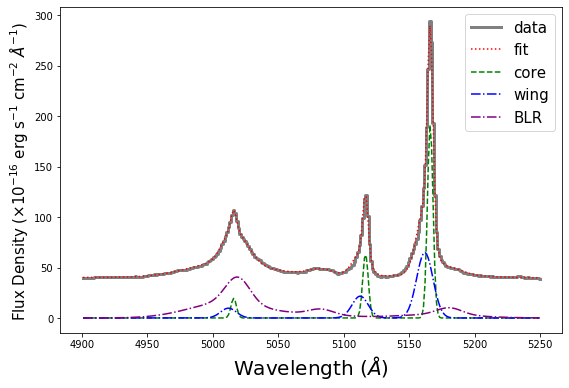

No handles with labels found to put in legend.


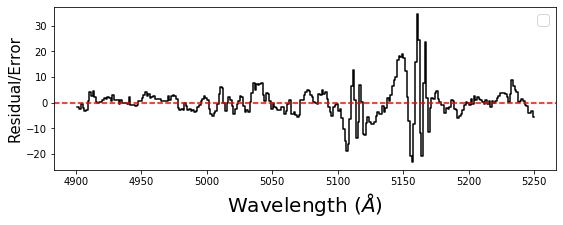

HE0345+0056
[-9048.104493328041, 2921.101586709405, 9047.174087096775, 323.0183423817778, 5465.778972008891, 1309.0818006674929, 9547.12139648032, -2174.033772495972, 45267.81551680314, 32.131627458199276, 9386.523581368854, 421.3935345179406, -30899.294106687154, 365.5585588481287, 9502.80690042875, 378.4204458998569, 1.1153153133210385, 74.35668483013052, -499.94730938354405, 4585.422409522403, 43.82212246385651] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


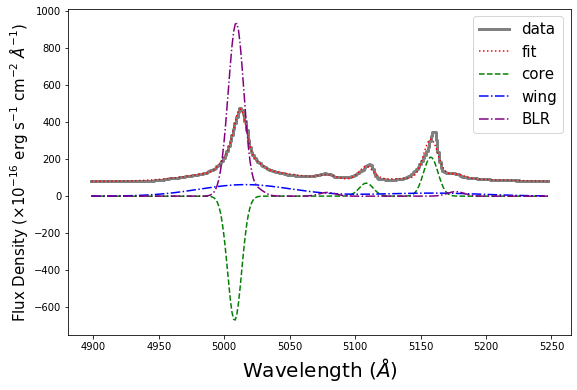

No handles with labels found to put in legend.


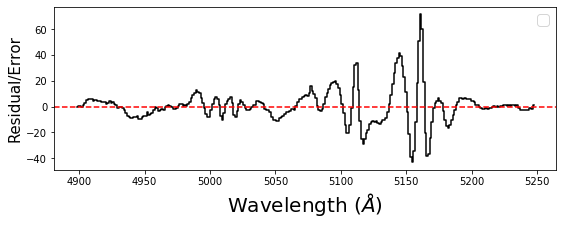

HE0351+0240
[77.82893352643988, 1200.6697992151235, 10638.513319403133, 70.13278097026381, 77.94627030379591, 178.28273489962552, 10617.302198672005, 239.38649504145178, 143.55867207137717, 8.228202827098285, 11578.583889869647, 316.5824956747622, 1388.9777171263413, 144.7118238130834, 10655.082776572568, 1304.7901573935433, -3.5763612697544875, 31.68260672825463, 21.211120731128176, 291.49545807528085, 43.35713789231039] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


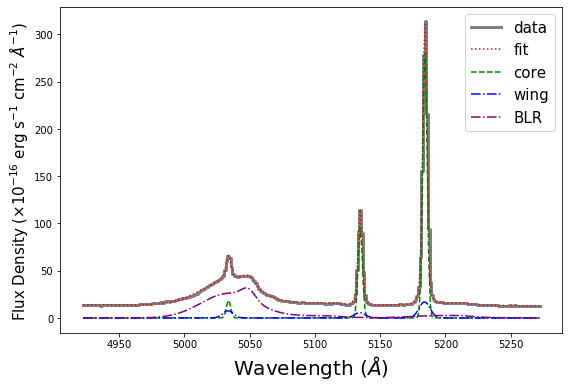

No handles with labels found to put in legend.


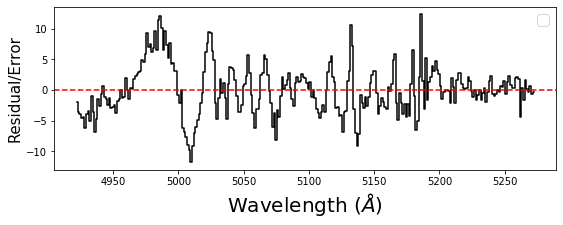

HE0412-0803


IndexError: index -1 is out of bounds for axis 0 with size 0

In [14]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0021-1810':False,'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0212-0059':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False
        ,'HE0253-1641':True,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True
        ,'HE0433-1028':True,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False
        ,'HE1029-1831':True,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1237-0504':False
        ,'HE1248-1356':False,'HE1330-1013':True,'HE1353-1917':True,'HE1417-0909':False,'HE2128-0221':False
        ,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}
#'HE0021-1810':False,
p_init= {'HE0021-1810':[1.2078169642715146, 17.216305909165907, 16109.438508035631, 109.45461271403255, 0.3200326636674963, 10.221646289889714, 16011.042931381086, 299.0455462447658, 1.2124073142121425, 1.8963130746612582, 10860.525666229707, 2396.6708995937574, 0.0, 0.0, 15959.0, 1000.0, 1.1610606174311213, 1.7778000884751866]
        ,'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
        ,'HE0040-1105':[1.139,1.5,12507.0,-50.0,1.0,3.0,12307.0,100.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
        ,'HE0108-4743':[39.237577877692715, 85.34149337269689, 7162.202253621596, 41.6939380680647, 4.144422236073521, 59.5545447193721, 7103.854580346932, 112.41008405668497, 5.925049122295072, 1.8055104262291544, 7035.4076987966255, 1281.3329615128491, 20.665960946360045, 3.710669187171524, 7181.556480474573, 430.8707020614182, 2.3022448079835613, -0.04967981643135043,]
        ,'HE0114-0015':[0.1,1.5,13680,120.0,1.0,3.0,13480,350.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
        ,'HE0119-0118':[18.05660859811562, 84.4095920594828, 16343.021367740042, 107.93509209640831, 1.2207224297067296, 65.33996725221164, 16133.361326639886, 241.44542909661888, 10.064952589397885, 0.11922164437143162, 16511.393117676984, 896.3989433325039, 10.634478954988479, 3.3663405963934196, 16351.30789876013, 2390.1171038535563, -12.276316410607894, 79.98110082727592]
        ,'HE0212-0059':[4.785770185809503, 55.77832394058257, 7920.6098244217255, 171.99703901261174, 0.4820655003901233, 5.605123767462352, 7641.049621205695, 439.79913411981, 7.173470331655197, 2.3435094620198083, 6910.053929265311, 3898.3687119322854, 1.901552737188031, 0.8937136428732486, 4628.357538385874, 891.2555075435819, 1.3723940319852157, 0.5501397045686803]
        ,'HE0224-2834':[7.06899403e+00,7.13458601e+01,1.79847558e+04,1.18000676e+02,1.45515224e+00,1.90068487e+01,1.79693125e+04,2.72340813e+02,8.44672986e+00,9.16885096e-01,1.80245745e+04,2.16641488e+03,0,0,0,0,-2.79613744e+00,2.29434665e+01]  
        ,'HE0227-0913':[50.394679609204886, 82.38595301209206, 4793.553851128582, 139.88069655713375, 28.334366378774646, 8.270912161070783, 4343.3627305096015, 308.9287526642564, 43.58112286442538, 6.768950196643075, 4712.578629985357, 1342.2135348231159, 97.23593356125787, 23.388212689292676, 4919.903960937358, 381.7006010971896, -8.85811095519379, 87.8870426811849]
        ,'HE0232-0900':[62.605607017687824, 659.5795559185437, 12876.601985964977, 145.11325604884192, -0.2617074297463765, 162.88547079243193, 12840.898228929938, 326.7436588011667, 97.58591538905621, 14.255215198867113, 12915.831641801858, 2205.2249730825406, 0.0, 0.0, 12942.0, 1000.0, -53.429934070509354, 375.842451064523]                                     
        ,'HE0253-1641':[19.377149011896083, 192.7222508141221, 9545.035688456925, -106.35104204745565, 9.719346198961993, 65.0583386642486, 9296.794498367248, 364.06553165818605, 25.906672696934077, 6.895005665433797, 9726.759430932016, 564.0994046997976, 14.992468948042934, 3.510123911144558, 9170.595823218708, 1730.073739918069, -1.4264470101175397, 47.223653086378945]
        ,'HE0345+0056':[14,180,9300,155,45,123,9100,400,90,18,9300,1500,270,26,9300,400,-7.0,7.16315181e+00]
        ,'HE0351+0240':[18.8530696879267, 287.3703000282673, 10638.538066989542, 70.08455323405626, 7.662275810864878, 17.13831158878082, 10617.184319528338, 238.5930464950352, 10.807426888249795, 0.6027815252673413, 11578.256339143716, 316.04972218771235, 26.062432526710936, 2.6529451225253653, 10656.512134188159, 1304.9068300414383, -3.606660078401498, 31.83983648710957]
        ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
        ,'HE0429-0247':[0.9,8.5,12627,150,0,2.0,12577,300,1.7,0.07,12627,680,1.3,0.2,12627,800,-0.5,4.0]        
        ,'HE0433-1028':[13.498327738787719, 82.0038452771689, 10588.870077859361, 128.10869355257955, 8.4564105787741, 88.98007865504046, 10276.46162253977, 335.3029464396524, 41.237538967081335, 4.233996031305976, 10497.133643970596, 921.6592764548924, 21.289414889397193, 5.680421741006004, 11223.444549651473, 2035.0985618206864, -16.914740179876567, 117.31097424928865]
        ,'HE0853+0102':[0.1,0.9,15600,50.0,0.1,0.1,15400,100.0,0.1,0.1,15600,1000.0,0.1,0.1,15600,1000.0,-0.001,0.1]
        ,'HE0934+0119':[11,47,15101,60.0,7,24,14901,166.0,28,3.0,15101,1000.0,3,1,15101,2300.0,0.001,0.7]
        ,'HE1011-0403':[6,40,17494,60.0,6,6,17250,200.0,20,4,17494,1000.0,5,3,17494,500.0,0.001,0.7]
        ,'HE1017-0305':[2.55089728e+00,3.32156849e+01,1.46820125e+04,5.64484789e+01,2.28786530e+00,1.19069708e+01,1.46246427e+04,2.07784177e+02,1.56862010e+01,2.28537958e+00,1.45094059e+04,1.94310674e+03,0.00000000e+00,0.00000000e+00,1.49950000e+04,1.00000000e+03,-9.11022180e+00,6.17692724e+01]
        ,'HE1029-1831':[29.92406904,9.69755119,1.21143614e+04,8.07668227e+01,4.81209595,39.5124391,1.19885900e+04,2.28331414e+02,5.96071923,1.62662334,1.20872053e+04,1.73779109e+03,8.66239041,1.11424427,1.25113917e+04,8.45498652e+02,-3.48452009,28.51317335]
        ,'HE1107-0813':[2.73507036,8.85291082,1.75441648e+04,8.62933367e+01,4.33021185,2.62050124,1.73852413e+04,4.85119513e+02,17.72249816,6.91845574,1.75621524e+04,1.00209675e+03,18.13023644,2.78324572,1.68106602e+04,1.91890818e+03,-26.90993593,201.11155123]
        ,'HE1108-2813':[28,35,7200.0,50.0,11,28,7000.0,100.0,16,4.2,7200,1000.0,0,0,7200,1000.0,-8.3,60]
        ,'HE1126-0407':[1.00409949e+00,1.34246331e+01,1.80273208e+04,1.24499810e+02,2.46452048e+00,2.86320853e+00,1.77600119e+04,3.51254916e+02,9.96139933e+00,1.30416561e+00,1.80789175e+04,7.18418498e+02,7.31717375e+00,1.77825637e+00,1.79704287e+04,1.77768741e+03,-9.59655619e-01,1.47131358e+01]
        ,'HE1237-0504':[19.493785248422885, 224.66255315569256, 2489.6203758147267, 103.76802785812963, 13.476391114686468, 35.681396900654065, 2303.3587316914345, 307.4720563892651, 37.87467629974615, 9.794924619485137, 2453.386220593742, 1679.5681005818321, 0.1, 0.1, 2700.0, 1000.0, -2.658895103852454, 24.09433037900086]
        ,'HE1248-1356':[15,70,4395.0,60.0,1.0,3.0,4195.0,-200.0,1.0,1.0,4395,1000.0,0,0,0,0.0,-0.001,2.0]     
        ,'HE1330-1013':[3.76936095,16.16917122,6.74250778e+03,7.83251391e+01,1.66147304,3.21416158,6.58670246e+03,2.11776429e+02,3.09888431,1.38119428,6.96871099e+03,1.89442503e+03,6.77647519,0.76391275,6.82636521e+03,6.40081695e+02,-3.75920925,24.29039856]
        ,'HE1353-1917':[5.27578675, 48.43043786,1.04881708e+04,8.19955922e+01,1.05886351,6.80260728,1.03058462e+04,4.92698762e+02,2.15521829,0.39784443,8.58992694e+03,1.49126858e+03,3.16250194,0.15731047,1.23263840e+04,1.56483974e+03,-0.001,0.002]
        ,'HE1417-0909':[7,100,13200,50.0,1.6,20,13000,100.0,10,1.2,13200,1000.0,0,0,13200,1000.0,-0.001,0.1]      
        ,'HE2128-0221':[4.296778179654671, 38.42538899120943, 15756.519327412814, 50.31479398258997, 3.966839343641518, 11.557385849412487, 15724.475034057066, -140.61219715104798, 5.259163130046745, 0.6418817379477669, 15833.958806117278, 885.7081797795291, 0.0, 0.0, 15744.0, 1000.0, -0.40793445077875623, 6.011008608795197]
        ,'HE2211-3903':[10,42,11914,50.0,2,5,11714,100.0,5,1,11914,1000.0,0,0,11914,100.0,-0.001,0.2]
        ,'HE2222-0026':[2.460621313038406, 7.634806779400478, 17417.939139239857, 120.3503410759872, -0.18144337166900082, 3.0698932814920514, 17251.72112349794, 235.78636808210186, 2.6311072711227523, 0.2093100816151153, 18542.81813314071, 614.8103641703985, 3.748413775741454, 0.5725089001892666, 17452.695689891858, 1680.08802962123, -0.1019674970820994, 3.8912963317877263]
        ,'HE2233+0124':[1.2,8.9,1.69833290e+04,1.62971108e+02,0.45,1.5,1.70411796e+04,4.92594446e+02,1.26,0,1.52006283e+04,1.41993597e+03,1.9,0.1,1.83718450e+04,4.09727643e+03,-3.96372168e-01,4.44439203e+00]
        ,'HE2302-0857':[30.08125075371935, 263.4915852081613, 14102.405012933865, 174.78361692454274, 5.234420820727908, 50.4264020928591, 14272.099786366725, 443.97703620906793, 12.465653653818647, 0.580439422201921, 15513.985182493981, 1399.4338046978553, 21.789736064188695, 7.5818140724399505, 12827.562641126544, 2106.3011612081536, -10.076688456785302, 88.0473440529682]}
#'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15956,100.0,1.0,1.0,16056,1000.0,0,0,16056,1000.0,-0.001,2.0]
        
for obj in objs:
    spectroastrometric_script(obj,p_init[obj],z[obj],broad2[obj])   